In [1]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image    

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import Image

from os import listdir
from os.path import isfile, join

tf.compat.v1.disable_eager_execution()
seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
dirname = os.getcwd()

train_path = os.path.join("/",dirname, 'OCT2017/train')
train_normal_pth = os.path.join("/",train_path, 'NORMAL')
train_dme_pth = os.path.join("/",train_path, 'DME')
train_drusen_pth = os.path.join("/",train_path, 'DRUSEN')
train_cnv_pth = os.path.join("/",train_path, 'CNV')

test_path = os.path.join("/",dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')

val_path = os.path.join("/",dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')

## Image visualisations : 

- With `get_specific_image` : we plot a specific image from its path. 

Here we plot a DME image : 

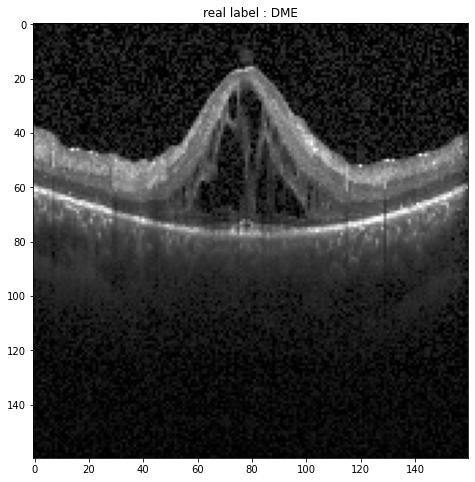

In [3]:
from visualisations import get_specific_image, get_random_image_from_class

path_dme = test_path + "/DME/DME-1102486-2.jpeg"    
img = get_specific_image(path_dme, visualize = True)

- With `get_random_image_from_class`, we plot a random image belonging to a given class : 

Here, we plot a random image from the class 'normal' present in the test set : 

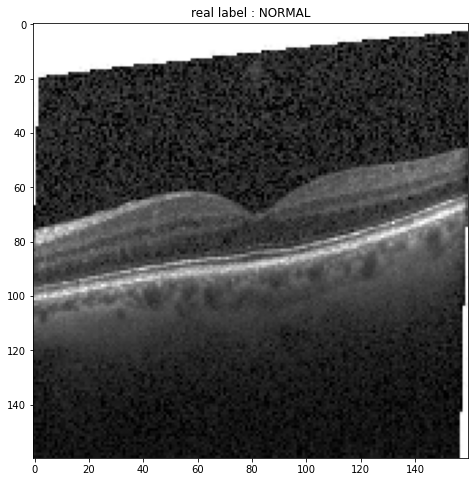

In [4]:
img = get_random_image_from_class(test_normal_pth, visualize = True)

We visualize an image from each class : 

### Normal retina : 

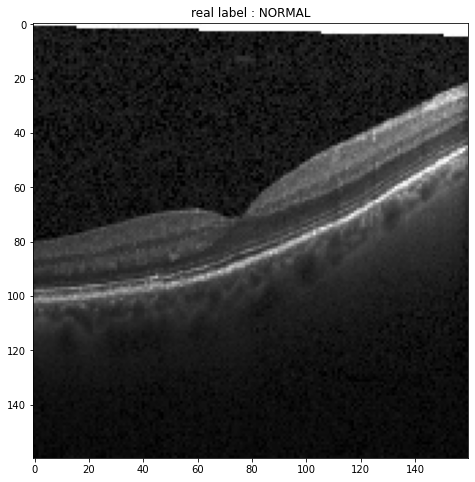

In [5]:
normal_img = get_random_image_from_class(train_normal_pth, visualize = True)

### Diabetic macular Edema : 

Diabetic macular edema (DME) is a complication of diabetes. People with type 1 or type 2 diabetes can develop DME.

DME occurs when excess fluid starts to build up in the macula of the eye. The macula allows us to focus and see fine details. It’s located in the center of the retina, the lining at the back of the eye that’s full of blood vessels.

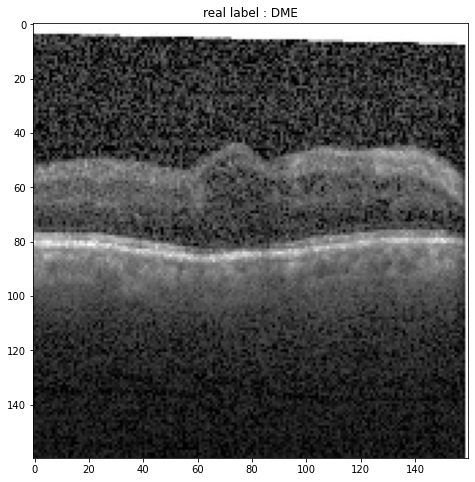

In [6]:
dme_img = get_random_image_from_class(train_dme_pth, visualize = True)

### DRUSEN : 

Drusen are deposits of extracellular waste that accumulate under the retina, between a specialized layer of cells called the retinal pigment epithelium (RPE) and Bruch's membrane, a meshwork of fibrous proteins (mostly collagen). 

The RPE helps maintain the photoreceptors (the light-sensing cells that make up the bulk of the retina), transporting nutrients and wastes between the photoreceptors and the blood vessels that supply them. 

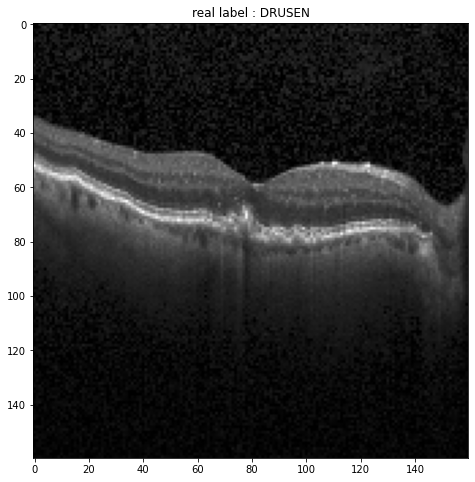

In [7]:
drusen_img = get_random_image_from_class(train_drusen_pth, visualize = True)

### Choroidal Neovascularization (CNV) 

Choroidal neovascularization (CNV) is the creation of new blood vessels in the choroid layer of the eye. Choroidal neovascularization is a common cause of neovascular degenerative maculopathy (i.e. 'wet' macular degeneration) commonly exacerbated by extreme myopia, malignant myopic degeneration, or age-related developments.

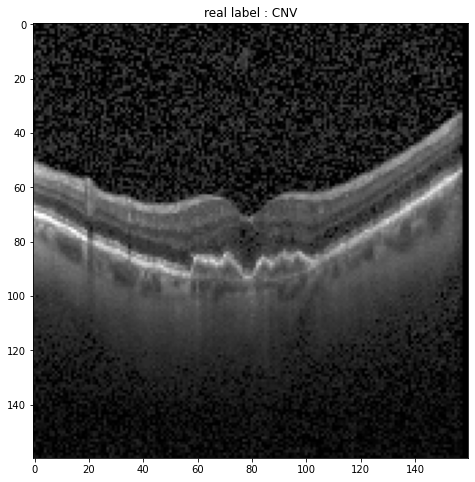

In [8]:
cnv_img = get_random_image_from_class(train_cnv_pth, visualize = True)

### Some informations about the data set : 

In [9]:
input_path = "OCT2017/"
for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 242, DME images: 242, DRUSEN images: 242, CNV images: 242
val, Normal images: 8, DME images: 8, DRUSEN images: 8, CNV images: 8


### Model definition :  

In [10]:
PARAMS = {'img_dims': 160,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }

We creat the test and train generators : 

In [11]:
from preprocessing import process_data

train_gen, test_gen = process_data(train_path, test_path, PARAMS['img_dims'], PARAMS['batch_size'])

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


We creat the model. We load the pretrained model weights from the file 'checkpoint.hdf5' : 

In [12]:
from model import model

model1 = model(PARAMS)
model1.load_weights('checkpoint.hdf5')

$\textit{Note}$ : the model can be trained using model_trainer in model.py

In [13]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 80, 80, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 80, 80, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128   

Accuracy of the model : 

In [14]:
accuracy = model1.evaluate(test_gen)
print('Accuracy of the model :', accuracy)

C:\Users\Akesbi Kamil\Anaconda3\envs\tp1\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy of the model : [0.027526553292127866, 0.9958678]


### Predictions : 

Classes of the data set : 

In [15]:
test_gen.class_indices
classes = {v: k for k, v in test_gen.class_indices.items()}
print('classes of the data set : ', classes) 

classes of the data set :  {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}


We take an image from the class DME in the test set, and check if the model correctly predict its class : 

In [16]:
from utils import prediction, predicted_testset_labels, real_testset_labels

In [17]:
path = test_path + "/DME/DME-1102486-2.jpeg"    

print('predicted class : ', classes[prediction(model1, path)])
print('real class : ', path.split('/')[-2])

predicted class :  DME
real class :  DME


## Confusion Matrix : 

In [18]:
predicted_labels = predicted_testset_labels(model1, test_gen)

In [19]:
test_labels = real_testset_labels(model1, test_gen)

Text(0.5, 42.0, 'Predicted label')

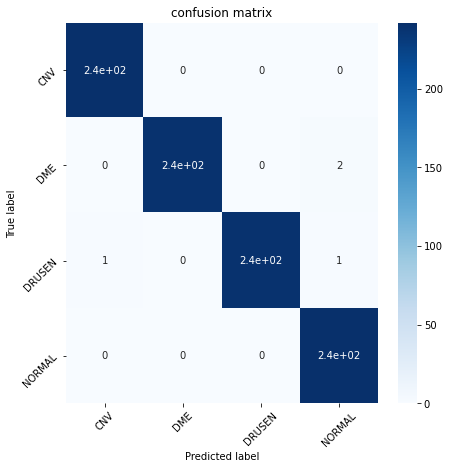

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(test_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(7,7 ))
sn.heatmap(cm,  cmap = plt.cm.Blues, ax = ax, annot = True)
plt.title('confusion matrix')
labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
ax.set_xticklabels( labels, rotation=45)
ax.set_yticklabels(labels, rotation=45)
plt.ylabel('True label')
plt.xlabel('Predicted label')

There are only 4 images that are predicted wrong : 

- 2 DME classified as 'normal'.
- 1 Drusen classified as 'CNV'.
- 1 Drusen classified as 'normal'.

We keep the indexes of the corresponding images : 

In [21]:
incorrects = np.nonzero(test_labels != predicted_labels)
incorrects

(array([339, 424, 644, 670], dtype=int64),)

### Filter visualisation : 

First, we get the positions and number of features of each $\textbf{convolutional}$ $\textbf{layer}$ of the model : 

In [22]:
from utils import get_cnnlayers_positions_in_model

In [23]:
positions = get_cnnlayers_positions_in_model(model1)
positions

[[1, 'conv2d', 16],
 [2, 'conv2d_1', 16],
 [4, 'separable_conv2d', 32],
 [5, 'separable_conv2d_1', 32],
 [8, 'separable_conv2d_2', 64],
 [9, 'separable_conv2d_3', 64],
 [12, 'separable_conv2d_4', 128],
 [13, 'separable_conv2d_5', 128],
 [17, 'separable_conv2d_6', 256],
 [18, 'separable_conv2d_7', 256]]

We plot the filters of the first convolutional layers : 

In [26]:
from visualisations import plot_filters

No handles with labels found to put in legend.


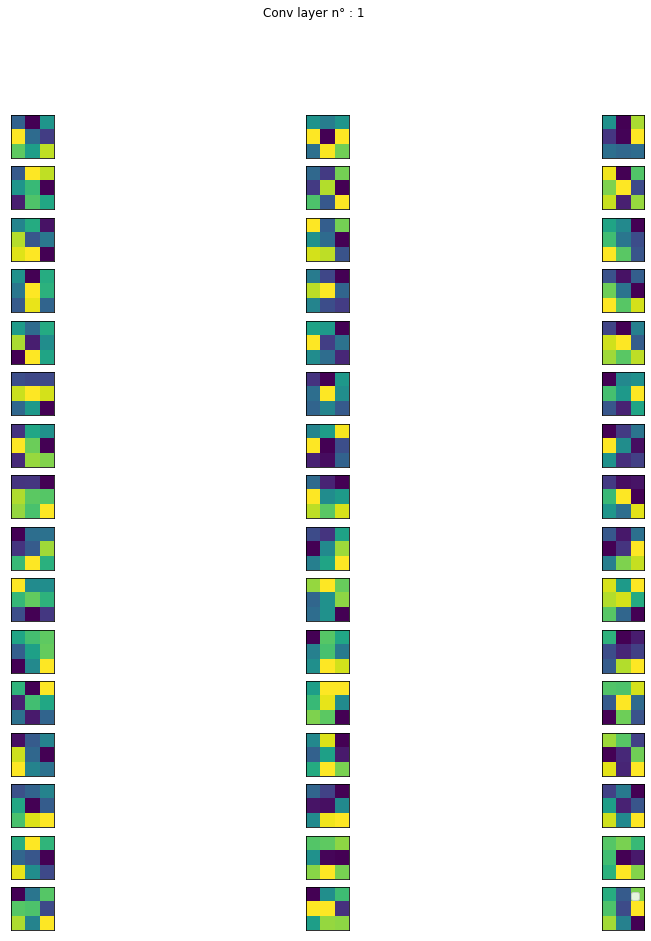

In [27]:
plot_filters(model1, 1)

The filters do not seem to provide any particular interpretable information...

### Feature Map Visualisation : 

In [28]:
from visualisations import get_feature_map

Here the idea is to find a feature map that appears to highlight well differences between classes : 

Observing feature maps from deep convolutional layers isn't really interesting because the feature map doesn't look like the initial picture anymore :

- If we observe a feature map from convolutional layer in position 18 for example, we get the following result : 


In [29]:
img_normal = get_random_image_from_class(test_normal_pth, False)
feature_map_normal_18 = get_feature_map(model1, 18, img_normal, visualize = False)

C:\Users\Akesbi Kamil\Anaconda3\envs\tp1\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


First feature map from last convolutional layer : 


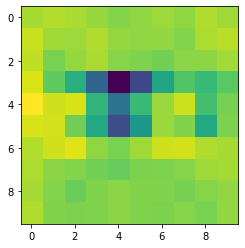

In [30]:
print("First feature map from last convolutional layer : ")
plt.imshow(feature_map_normal_18[0,:,:,0])

The feature map from conv in position 18 isn't interpretable here, we better focus on low level convolutional layers in orther to find a feature map that could bring out some relevant information :   

- $\textbf{First}$ $\textbf{feature}$ $\textbf{map}$ from the $\textbf{second}$ $\textbf{convolutional}$ $\textbf{layer}$ seems interesting : 

##### Normal image : 

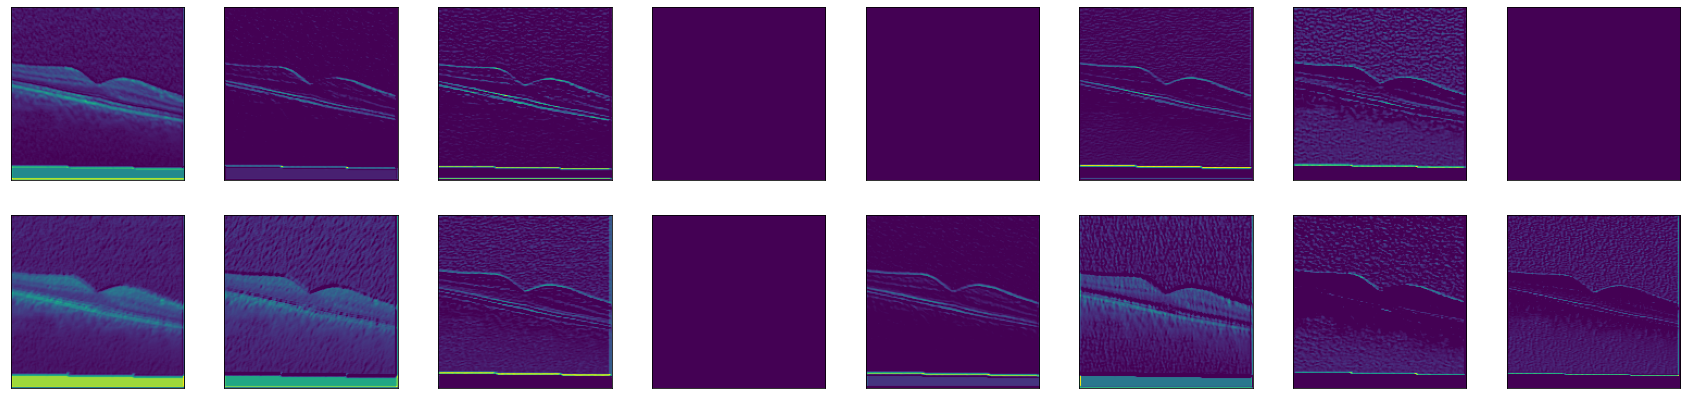

In [32]:
img_normal = get_random_image_from_class(test_normal_pth, False)
feature_map_normal = get_feature_map(model1, 2, img_normal)

Text(0.5, 1.0, 'Selected feature map observed for a normal image')

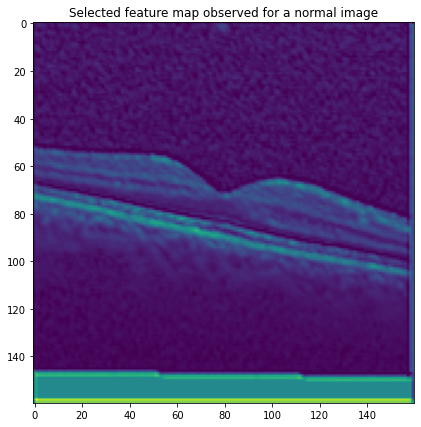

In [33]:
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_normal[0,:,:,0])
plt.title('Selected feature map observed for a normal image')

##### DME : 

In [34]:
img_dme = get_random_image_from_class(test_dme_pth, False)
feature_map_dme = get_feature_map(model1, 2, img_dme, visualize = False)


Text(0.5, 1.0, 'selected feature map observed for a DME image')

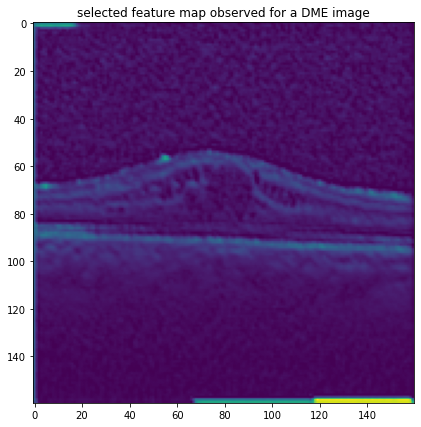

In [36]:
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_dme[0,:,:,0])
plt.title('selected feature map observed for a DME image')

##### Drusen : 

In [37]:
img_drusen = get_random_image_from_class(test_drusen_pth, False)
feature_map_drusen = get_feature_map(model1, 2, img_drusen, visualize = False)

Text(0.5, 1.0, 'selected feature map observed for a Drusen image')

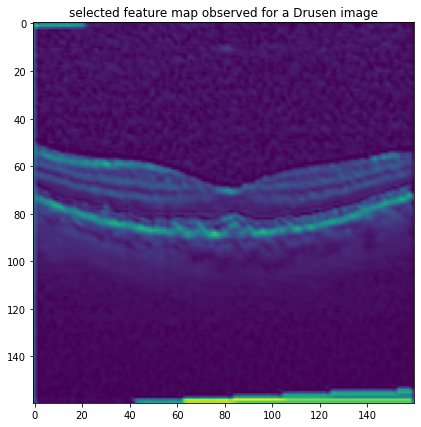

In [38]:
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_drusen[0,:,:,0])
plt.title('selected feature map observed for a Drusen image')

##### CNV 

In [39]:
img_cnv = get_random_image_from_class(test_cnv_pth, False)
feature_map_cnv = get_feature_map(model1, 2, img_cnv, visualize = False)

Text(0.5, 1.0, 'selected feature map observed for a CNV image')

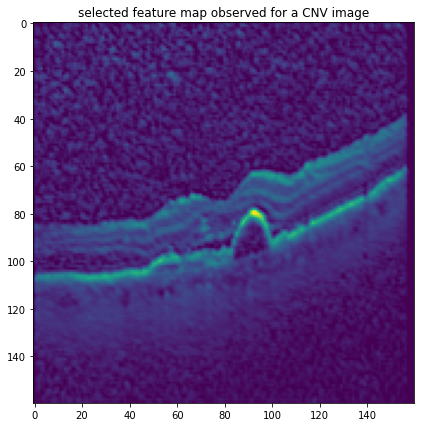

In [40]:
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_cnv[0,:,:,0])
plt.title('selected feature map observed for a CNV image')

## HeatMap of last convolutional layer using Grad-CAM : 

$\textbf{Grad-CAM}$ (CAM = convolutional activation map) is a technique for vizualizing what parts of an image has the model focused on in order to make its prediction. 

- "Grad-Cam, unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest".

It is really easy to implement as it can be applied to any pretrained convolutional neural network (which is why it is interesting for our problem). 

For more informations : https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48

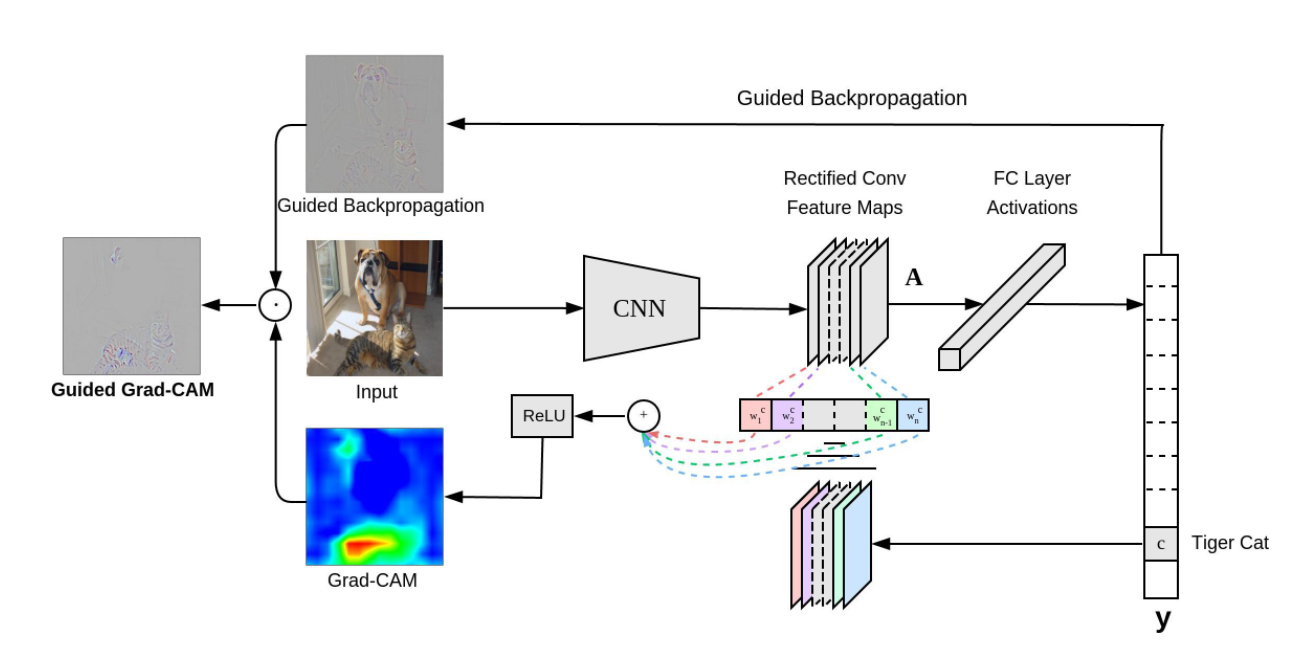

In [41]:
Image(filename='grad-CAM.png') 

The idea here is that grad-CAM could be a complementary tool coming with prediction that would comfort (or not) the result of the prediction : 

In [42]:
from visualisations import heatmap

#### Random normal image : 

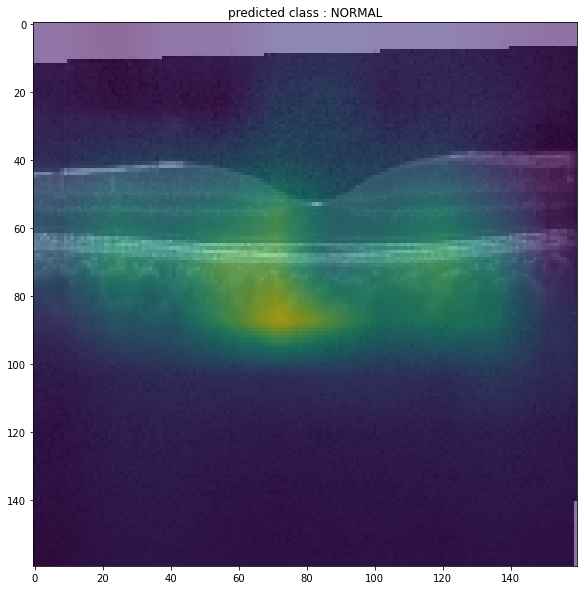

In [43]:
heatmap(model1, get_random_image_from_class(test_normal_pth, visualize = False))

#### random DME image : 

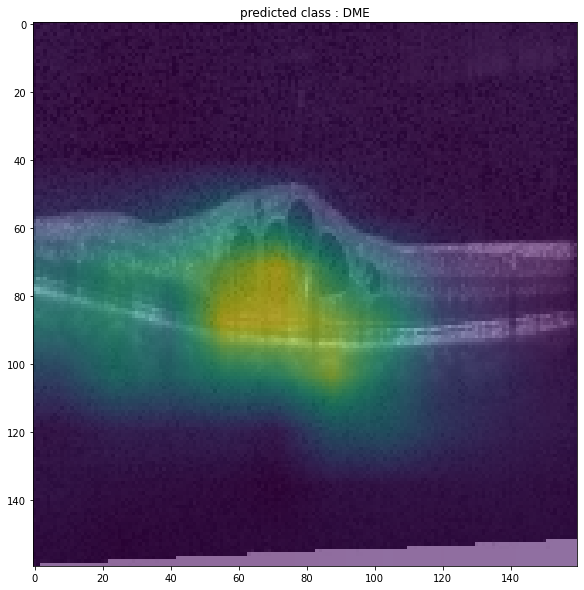

In [44]:
heatmap(model1, get_random_image_from_class(test_dme_pth, visualize = False))

#### Random drusen image 

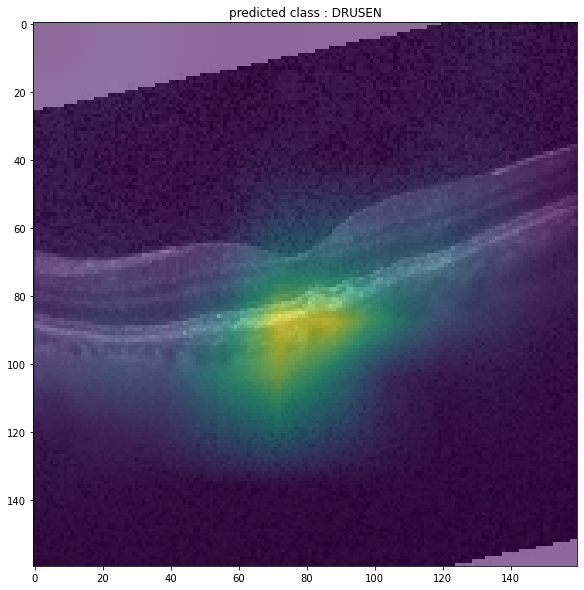

In [45]:
heatmap(model1, get_random_image_from_class(test_drusen_pth, visualize = False))

#### Random CNV image : 

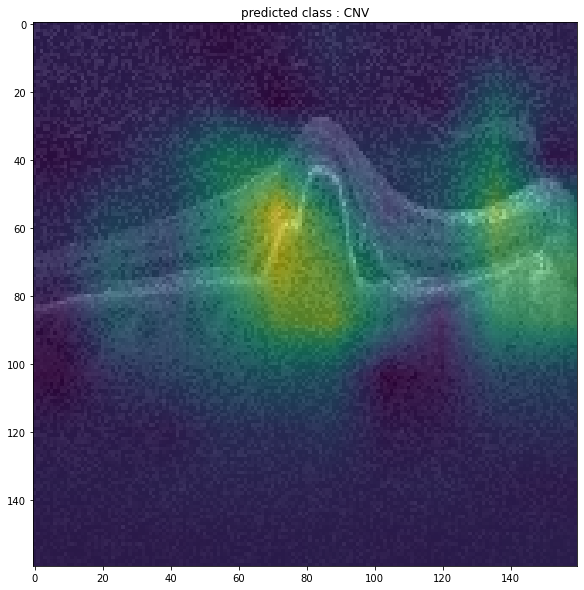

In [46]:
heatmap(model1, get_random_image_from_class(test_cnv_pth, visualize = False))

We can observe that the preceding images have been well classified. Moreover, the heatmap confirms that the prediction is correct because the activation part of the classifier is concentrated each time on the right retina region regarding its decision. 

### Heatmap for misclassified pictures : 

What happened for the 4 miscalssified pictures ? 

- We could observe the heatmaps and predictions of each misclassified picture in orther to understand what went wrong :  

In [47]:
incorrects

(array([339, 424, 644, 670], dtype=int64),)

###### Misclassified 1 : Real label : 'DME'  / predicted : 'Normal'

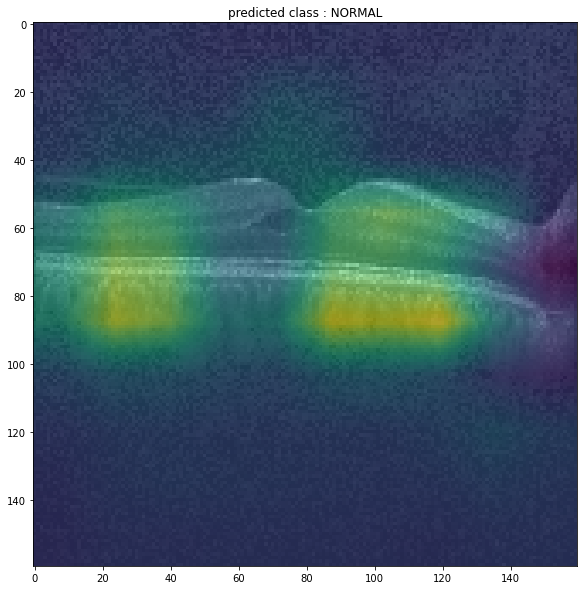

In [48]:
misclassified1 =test_gen[339//32][0][339%32]
misclassified1 = np.expand_dims(misclassified1,axis=0)
heatmap(model1, misclassified1) 

Here we can see that the classifier focuses on the RPE of the retina instead of the macula. A doctor could 
have easily observed that the macula contains fluid and thus conclude that this retina isn't normal but suffers from DME.

- CAM allows the doctor not to blindly trust the classifier (even if its accuracy is over 99%).

Combined with feature map, we got an even better tool : 

Text(0.5, 1.0, 'selected feature map observed for the misclassified image')

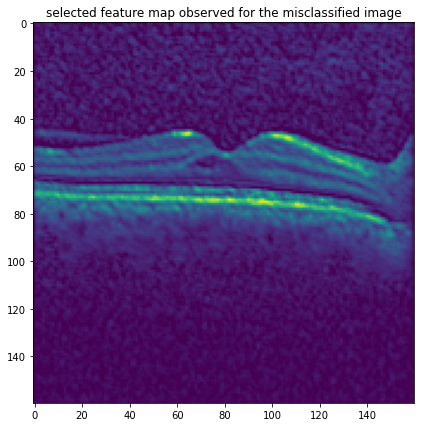

In [49]:
feature_map_miscl1 = get_feature_map(model1, 2, misclassified1, visualize = False)
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_miscl1[0,:,:,0])
plt.title('selected feature map observed for the misclassified image')

#### Misclassified 2 : real label : 'DME' / predicted : 'normal'

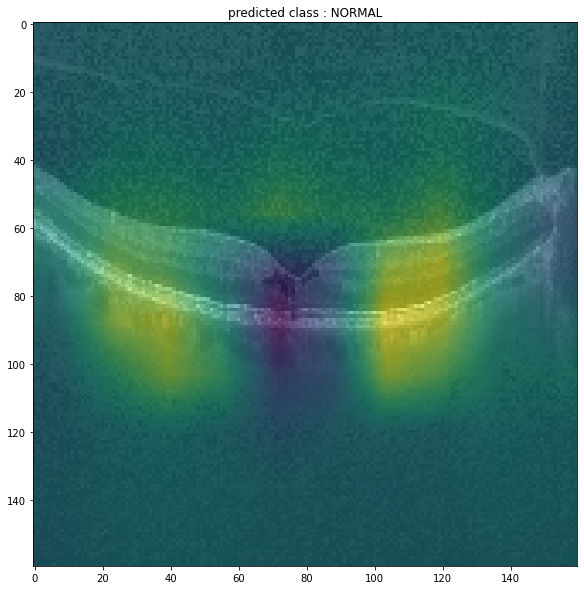

In [50]:
misclassified2 =test_gen[424//32][0][424%32]
misclassified2 = np.expand_dims(misclassified2,axis=0)
heatmap(model1, misclassified2) 


Text(0.5, 1.0, 'selected feature map observed for the misclassified image')

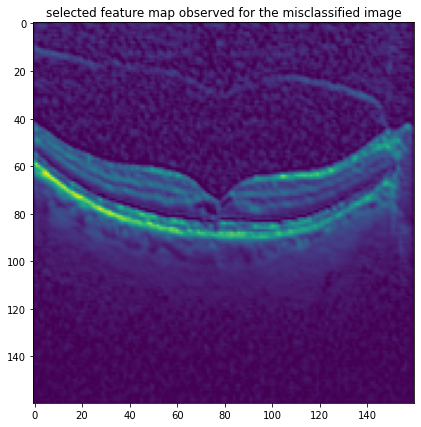

In [51]:
feature_map_miscl2 = get_feature_map(model1, 2, misclassified2, visualize = False)
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_miscl2[0,:,:,0])
plt.title('selected feature map observed for the misclassified image')

##### Misclassified 3 : real label : 'drusen' / predicted : 'CNV'

this example clearly illustrates the complementarity of the different tools:

- The prediction is wrong : the classifier predicted CNV instead of drusen. 
- However, the heatmap indicates that the classifier didn't concentrate on a specific part of the image but rather on the whole image, which indicates an anormal behviour. 
- The feature maps finally comes to help us conclude : we can clearly see that the retina here is of type 'drusen'. 

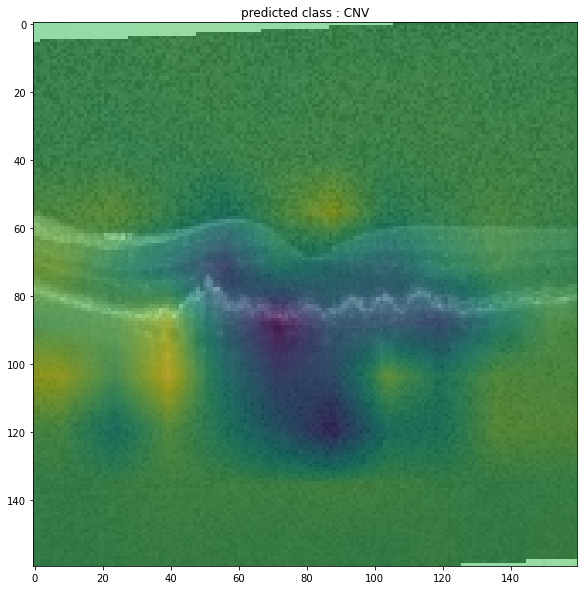

In [52]:
misclassified3 =test_gen[644//32][0][644%32]
misclassified3 = np.expand_dims(misclassified3,axis=0)
heatmap(model1, misclassified3) 
# real : drusen 

Text(0.5, 1.0, 'selected feature map observed for the misclassified image')

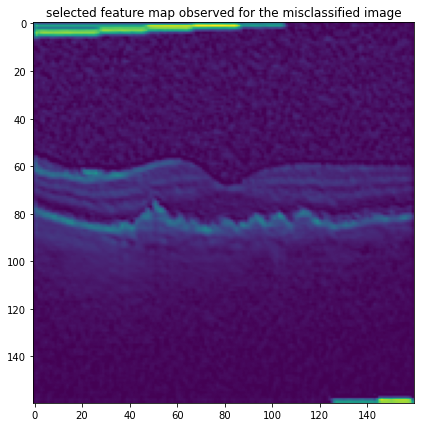

In [53]:
feature_map_miscl3 = get_feature_map(model1, 2, misclassified3, visualize = False)
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_miscl3[0,:,:,0])
plt.title('selected feature map observed for the misclassified image')

#### Misclassified 4 : real : 'drusen' / classified : 'normal' 

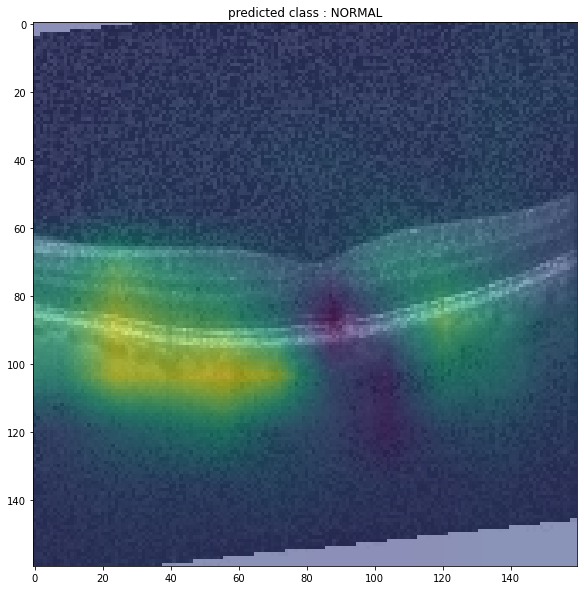

In [54]:
misclassified4 =test_gen[670//32][0][670%32]
misclassified4 = np.expand_dims(misclassified4,axis=0)
heatmap(model1, misclassified4) 


Text(0.5, 1.0, 'selected feature map observed for the misclassified image')

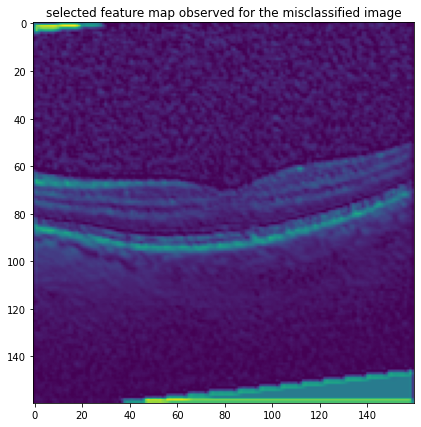

In [55]:
feature_map_miscl4 = get_feature_map(model1, 2, misclassified4, visualize = False)
plt.figure(figsize= (7, 7))
plt.imshow(feature_map_miscl4[0,:,:,0])
plt.title('selected feature map observed for the misclassified image')